In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [2]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
# pip install xlrd

     ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/96.5 kB ? eta -:--:--
     ------------ ------------------------- 30.7/96.5 kB 262.6 kB/s eta 0:00:01
     ---------------- --------------------- 41.0/96.5 kB 245.8 kB/s eta 0:00:01
     ------------------------ ------------- 61.4/96.5 kB 363.1 kB/s eta 0:00:01
     -------------------------------------- 96.5/96.5 kB 425.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Задание 3

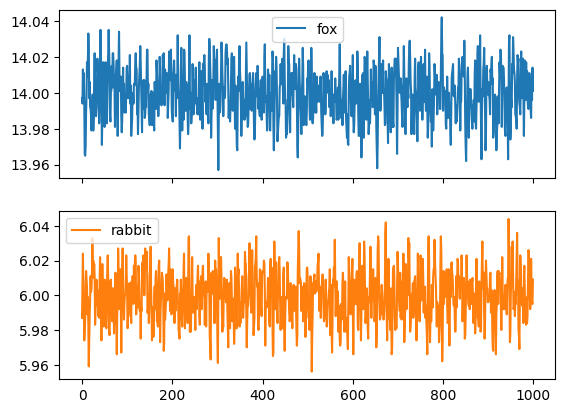

In [4]:
# df = pd.read_excel(r'fox_rabbit.xls')
# df = pd.read_excel(r'fox_rabbit.xlsx')
df = pd.read_csv(r'fox_rabbit.csv', sep=';', decimal=',')
df.plot(subplots=True);

In [5]:
adf_test(df.fox)
# ряд стационарный

Results of Dickey-Fuller Test:
Test Statistic                 -20.378058
p-value                          0.000000
#Lags Used                       2.000000
Number of Observations Used    997.000000
Critical Value (1%)             -3.436926
Critical Value (5%)             -2.864443
Critical Value (10%)            -2.568316
dtype: float64


In [6]:
adf_test(df.rabbit)
# ряд стационарный

Results of Dickey-Fuller Test:
Test Statistic                 -20.829655
p-value                          0.000000
#Lags Used                       2.000000
Number of Observations Used    997.000000
Critical Value (1%)             -3.436926
Critical Value (5%)             -2.864443
Critical Value (10%)            -2.568316
dtype: float64


In [7]:
model = VAR(df).fit(ic='bic') #, maxlags=10)
print(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Dec, 2023
Time:                     14:50:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.3181
Nobs:                     999.000    HQIC:                  -18.3364
Log likelihood:           6335.58    FPE:                1.07584e-08
AIC:                     -18.3476    Det(Omega_mle):     1.06941e-08
--------------------------------------------------------------------
Results for equation fox
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             3.894414         0.344174           11.315           0.000
L1.fox            0.519154         0.022522           23.051           0.000
L1.rabbit         0.472920         0.021925           21.570           0.000



In [8]:
print(model.roots)
print(np.absolute(model.roots)) # модуль комплексного числа
# все корни по модулю >1 => модель устойчива

[1.01531654+0.98676927j 1.01531654-0.98676927j]
[1.41583236 1.41583236]


In [9]:
(
    model
    .test_whiteness(adjusted=True, nlags=16)
    .summary()
) # 16 здесь для совпадения с выкладкой R, дефолт - 10

# нулевая гипотеза не отвергается => нет автокорреляции остатков

Test statistic,Critical value,p-value,df
50.14,79.08,0.814,60


In [10]:
print(
    het_arch(model.resid['fox'], ddof=1)
) # тестовая статистика, p-value, f-статистика, f p_value
print(
    het_arch(model.resid['rabbit'], ddof=1)
)

# het_arch -- arch с гетероскедастичностью

(6.551561424769888, 0.7669929161748021, 0.6528541716085065, 0.7686358664651611)
(12.152919666849217, 0.27495255000079893, 1.217973151092575, 0.2748873351788153)


In [11]:
(
    model
    .test_causality(caused='fox', causing='rabbit')
    .summary()
)
# rabbit -(GC)-> fox

Test statistic,Critical value,p-value,df
465.3,3.846,0.000,"(1, 1992)"


In [12]:
(
    model
    .test_inst_causality(causing='rabbit')
    .summary()
)
# rabbit /no/-inst->/ fox
# rabbit does not instantaneously cause fox
# то есть rabbit влияет на fox, но не сразу

Test statistic,Critical value,p-value,df
0.009158,3.841,0.924,1


[[14.00486389  6.00364137]
 [14.00433563  5.99901395]
 [14.00187298  5.99699958]
 [13.99964185  5.99726745]
 [13.99861024  5.99854369]
 [13.99867823  5.99970289]
 [13.99926174  6.00024049]
 [13.99981891  6.0002068 ]
 [14.00009223  5.99990449]
 [14.00009116  5.99961505]]


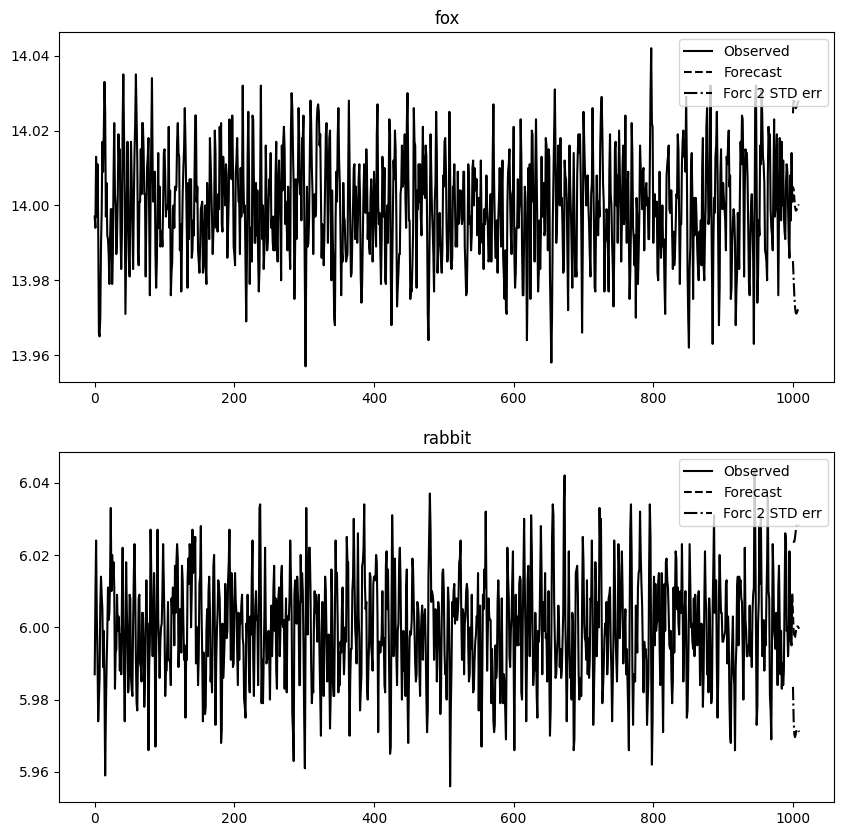

In [13]:
lag_order = model.k_ar
fc = model.forecast(y=df.values[-lag_order:], steps=10)
print(fc)
model.plot_forecast(steps=10, );

# ниже исправляем эту ерунду

In [15]:
fc_int = np.array(
    [
        fc - 1.96*np.sqrt(model._forecast_vars(steps=10)),
        fc + 1.96*np.sqrt(model._forecast_vars(steps=10))
    ]
)

In [16]:
len(fc[:, 0])

10

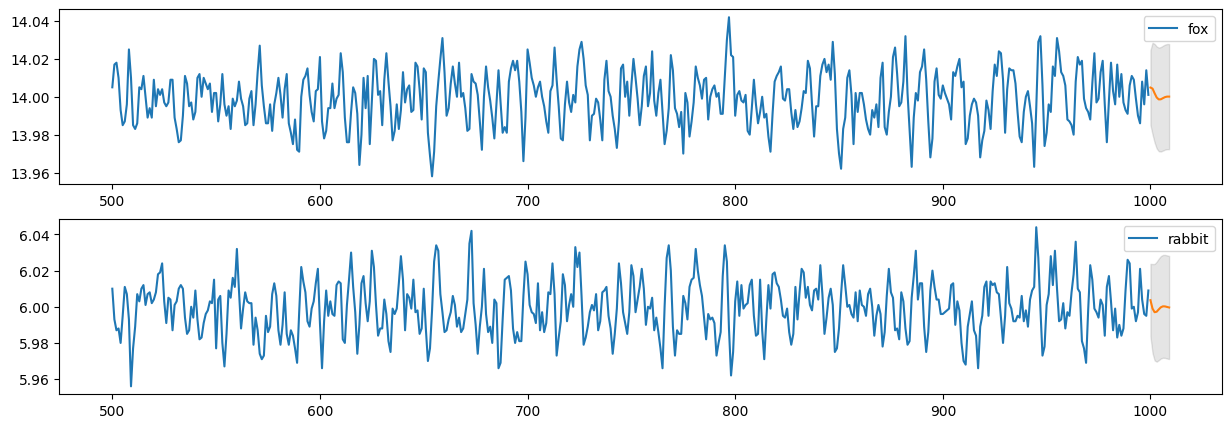

In [17]:
start = 500
fig, ax = plt.subplots(2, figsize=(15, 5))
df.iloc[start:, 0].plot(ax=ax[0], legend=True)
ax[0].plot(
    pd.DataFrame(
        fc[:, 0], index=range(
            df.shape[0], df.shape[0] + len(fc[:, 0])
        )
    )
)
ax[0].fill_between(
    x=range(
        df.shape[0], df.shape[0] + len(fc[:, 0])
    ), 
    y1=fc_int[0, :, 0], 
    y2=fc_int[1, :, 0], color='k', alpha=0.1
);

df.iloc[start:, 1].plot(ax=ax[1], legend=True)
ax[1].plot(
    pd.DataFrame(
        fc[:, 1], 
        index=range(
            df.shape[0], df.shape[0] + len(fc[:, 1])
        )
    )
)
ax[1].fill_between(
    x=range(
        df.shape[0], df.shape[0]+len(fc[:, 1])
    ), 
    y1=fc_int[0, :, 1], 
    y2=fc_int[1, :, 1], color='k', alpha=0.1
);

plt.show();

**ВАЖНО**: в VAR коэф не интерпретируемы

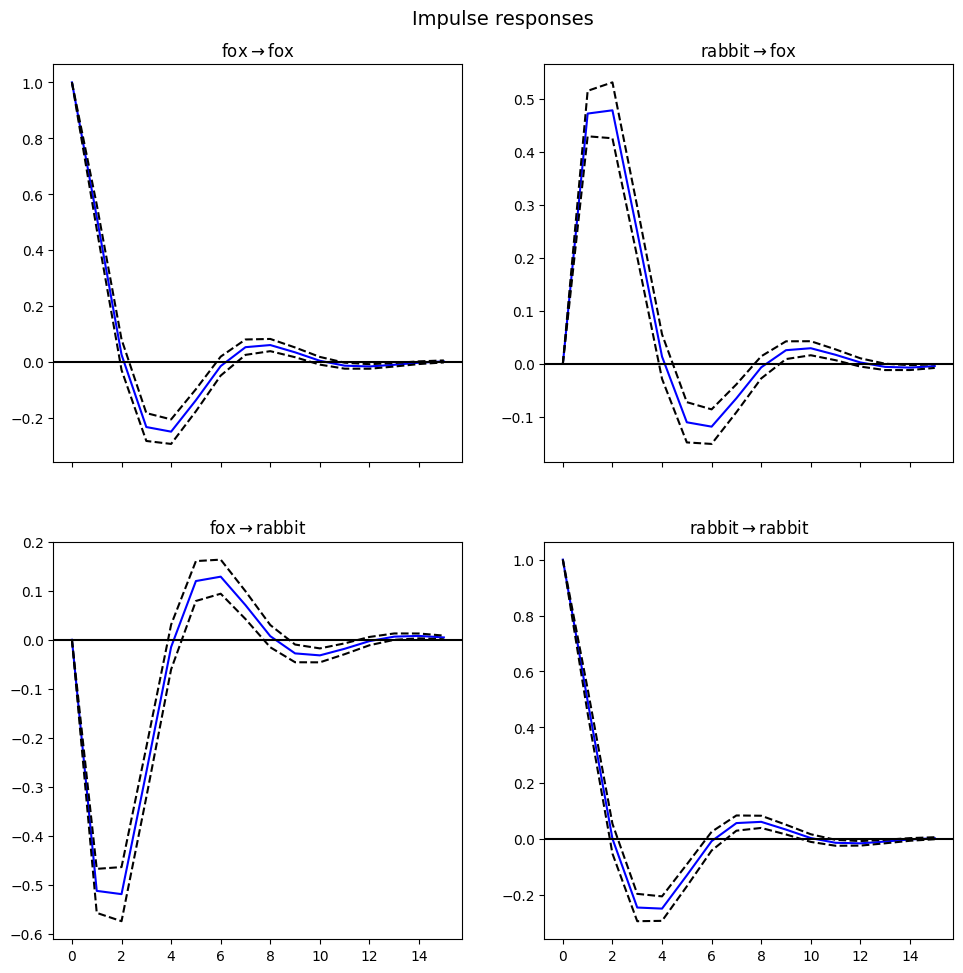

In [18]:
model.irf(15).plot();

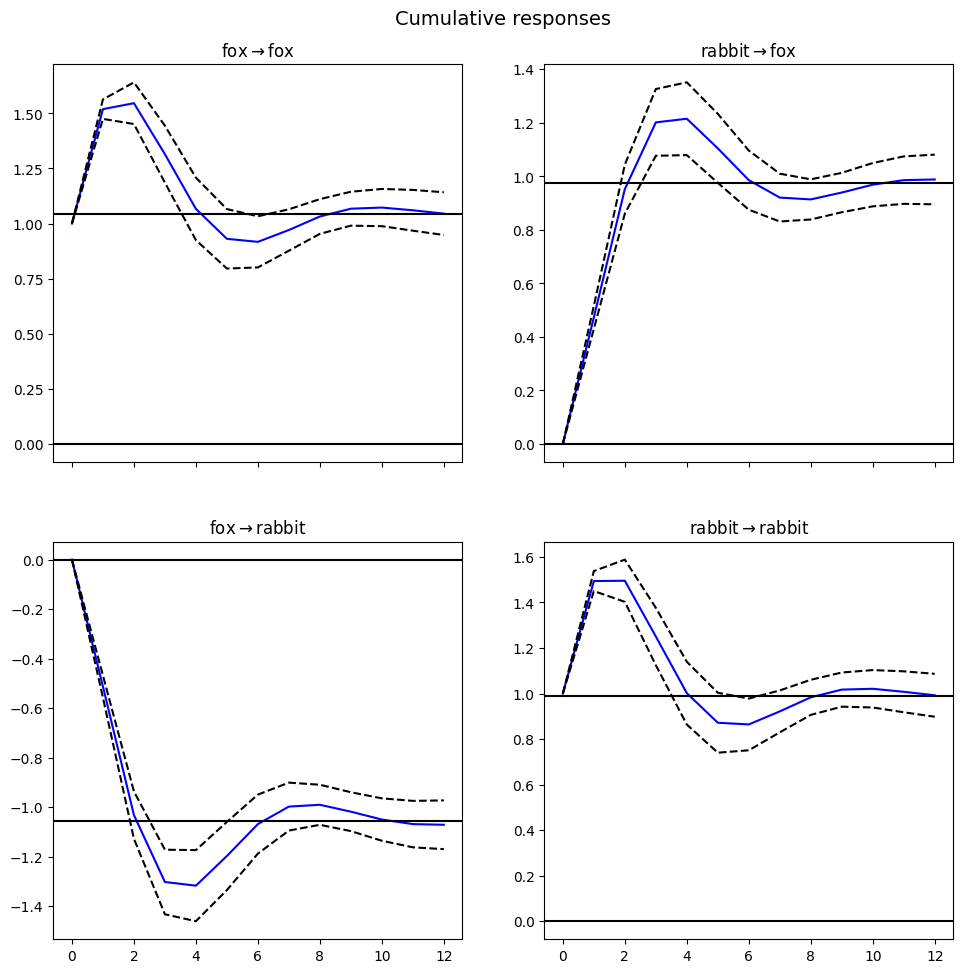

In [19]:
model.irf(12).plot_cum_effects();
# тут мы можем увидеть долгосрочное влияние шока

# Задание 4

Минутка боли: форматы Datetime в питоне

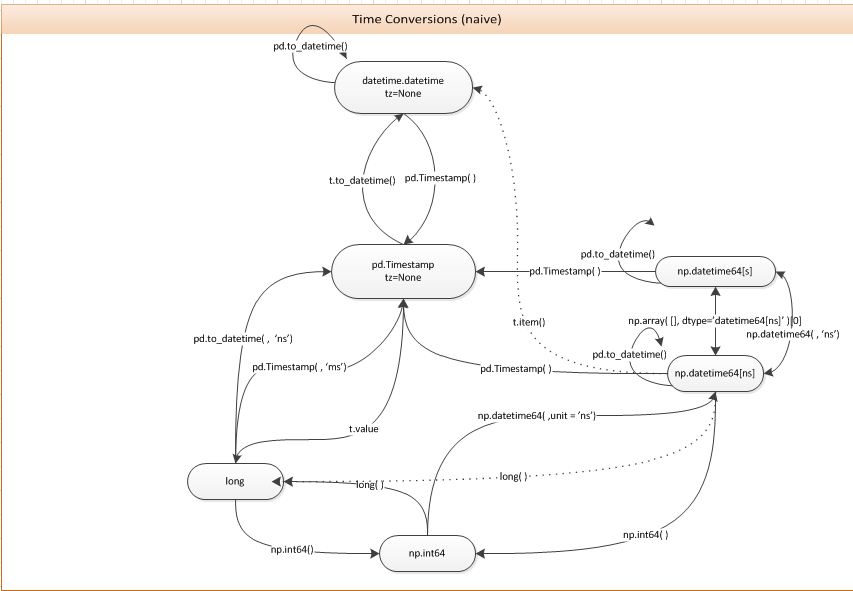

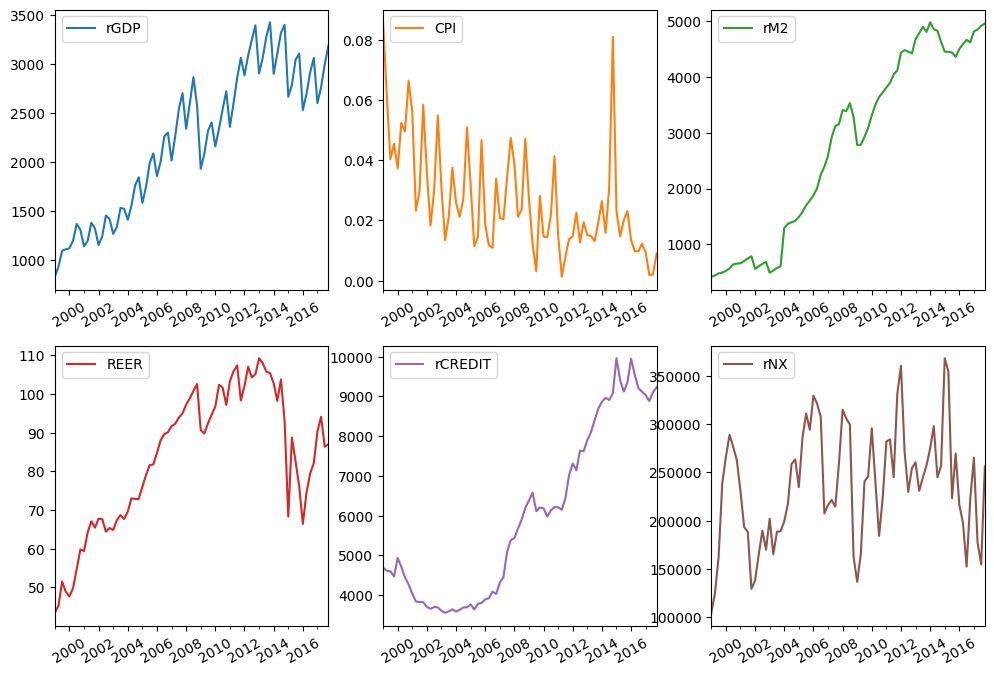

In [21]:
data = pd.read_csv(r'Data_SVAR1.csv', sep=';', decimal=',')
data.index = pd.date_range(
    start='3.1.1999', 
    periods = data.shape[0], 
    freq='Q'
)
data.plot(
    subplots=True, layout=[2, 3], 
    sharex=False, figsize=(12, 8), 
    rot=30
);

In [22]:
data_seasons = data.apply(
    lambda x: seasonal_decompose(x).seasonal 
)
# тут используется hp_filter или moving averages?
data_seasons

,rGDP,CPI,rM2,REER,rCREDIT,rNX
1999-03-31,-203.383031,-0.000400,-1.136448,-1.807691,87.469476,13229.365299
1999-06-30,-73.054719,-0.008471,3.467483,1.021892,-45.897626,1655.882975
1999-09-30,122.905742,-0.005120,28.296786,1.319740,-36.101922,-8817.148776
1999-12-31,153.532008,0.013992,-30.627821,-0.533941,-5.469928,-6068.099497
2000-03-31,-203.383031,-0.000400,-1.136448,-1.807691,87.469476,13229.365299
...,...,...,...,...,...,...
2016-12-31,153.532008,0.013992,-30.627821,-0.533941,-5.469928,-6068.099497
2017-03-31,-203.383031,-0.000400,-1.136448,-1.807691,87.469476,13229.365299
2017-06-30,-73.054719,-0.008471,3.467483,1.021892,-45.897626,1655.882975
2017-09-30,122.905742,-0.005120,28.296786,1.319740,-36.101922,-8817.148776


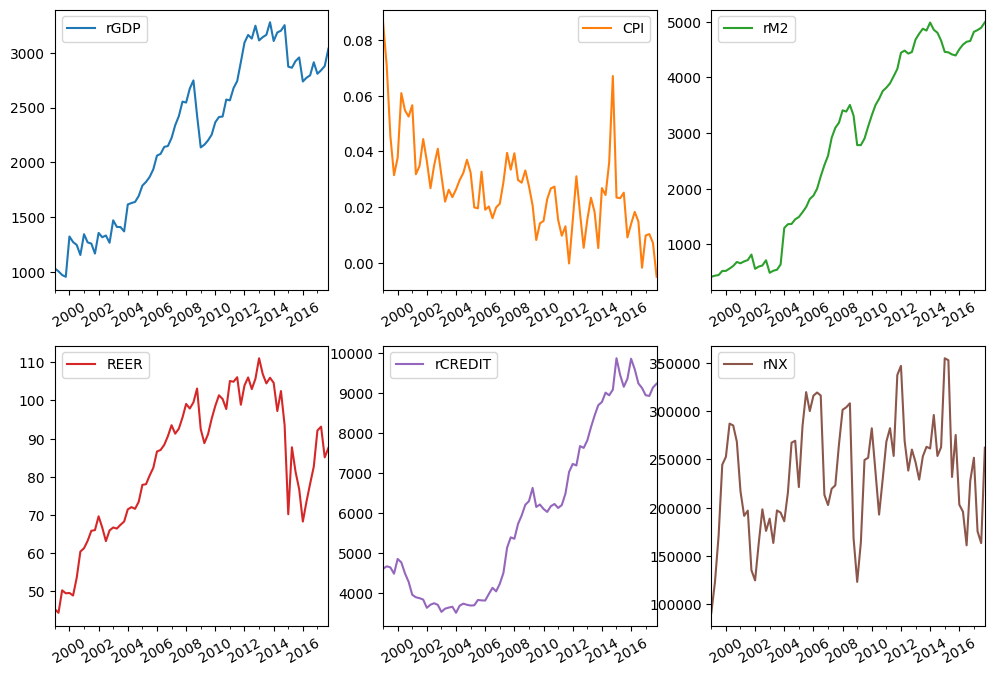

In [23]:
data_seas = data - data_seasons
data_seas.plot(
    subplots=True, layout=[2, 3], 
    sharex=False, figsize=(12, 8), 
    rot=30
);

In [201]:
for i in range(data_seas.shape[1]):
    print('\n', data.columns[i])
    adf_test(data_seas.iloc[:, i])


 rGDP
Results of Dickey-Fuller Test:
Test Statistic                 -1.180239
p-value                         0.682038
#Lags Used                      5.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64

 CPI
Results of Dickey-Fuller Test:
Test Statistic                 -4.386315
p-value                         0.000314
#Lags Used                      0.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64

 rM2
Results of Dickey-Fuller Test:
Test Statistic                 -0.674193
p-value                         0.853321
#Lags Used                      1.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.5880

In [24]:
# у нас две переменные характеризируют валютный курс, поэтому мы оценим два VAR и возьмем тот, который будет лучше
# точнее возьмем лучшее прокси для валютного курса с точки зрения информационного критерия модели

data_d_reer = (
    data_seas
    .diff()
    .drop(columns=['rNX'])
    .dropna()
)
data_d_nx = (
    data_seas
    .diff()
    .drop(columns=['REER'])
    .dropna()
)

In [25]:
(
    VAR(data_d_reer)
    .fit(maxlags=8, trend='c', ic='aic')
    .summary()
)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Dec, 2023
Time:                     15:21:31
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    29.7022
Nobs:                     67.0000    HQIC:                   25.6258
Log likelihood:          -1039.39    FPE:                2.53810e+10
AIC:                      22.9565    Det(Omega_mle):     2.33219e+09
--------------------------------------------------------------------
Results for equation rGDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -8.586008        25.372830           -0.338           0.735
L1.rGDP           -0.020013         0.199251           -0.100           0.920
L1.CPI           164.087861      1542.372611            0.106           0

In [27]:
(
    VAR(data_d_nx)
    .fit(maxlags=8, trend='c', ic='aic')
    .summary()
) # по информационным критериям модель с REER лучше

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Dec, 2023
Time:                     15:23:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    48.5200
Nobs:                     67.0000    HQIC:                   44.4436
Log likelihood:          -1669.79    FPE:                3.77570e+18
AIC:                      41.7743    Det(Omega_mle):     3.46939e+17
--------------------------------------------------------------------
Results for equation rGDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             17.193283        19.510859            0.881           0.378
L1.rGDP           -0.068593         0.198493           -0.346           0.730
L1.CPI          1811.678955      1606.442560            1.128           0

In [26]:
r_model = VAR(data_d_reer).fit(maxlags=1, trend='c') 
# в R подбор модели не предполагает возможности p=0, поэтому там минимальный лаг = 1
(
    r_model
    .test_whiteness(adjusted=True, nlags=23)
    .summary()
 ) # 23 здесь для совпадения с выкладкой R, дефолт - 10

Test statistic,Critical value,p-value,df
564.6,605.7,0.324,550


In [28]:
best_model = (
    VAR(data_d_reer)
    .fit(maxlags=8, ic='bic', trend='c')
) # в R подбор модели не предполагает возможности p=0, поэтому там минимальный лаг = 1
(
    best_model
    .test_whiteness(adjusted=True, nlags=23)
    .summary()
) # 23 здесь для совпадения с выкладкой R, дефолт - 10

Test statistic,Critical value,p-value,df
642.2,631.9,0.027,575


In [29]:
for i in range(best_model.resid.shape[1]):
    print(
        f'\n{best_model.resid.columns[i]}: ', 
        het_arch(best_model.resid.iloc[:, i], ddof=1)
    ) # тестовая статистика, p-value, f-статистика, f p_value


rGDP:  (11.235994056341553, 0.3394299886669906, 1.149919662450055, 0.34432339777113924)

CPI:  (14.757015634718151, 0.14117494241679368, 1.6182586302316184, 0.12627490049118656)

rM2:  (2.714781154659242, 0.9873627635081144, 0.23920642711834608, 0.990723959919034)

REER:  (18.016745179912498, 0.05468183021317397, 2.115779414749622, 0.0388147759995926)

rCREDIT:  (4.1497160530756645, 0.9403403511088178, 0.374408694643464, 0.9525126427910798)


## Моделирование SVAR

In [30]:
amat = np.asarray([
    ['E', 'E', 0, 0, 0],
    [0, 'E', 0, 'E', 0],
    ['E'] * 5,
    ['E', 'E', 0, 'E', 0],
    ['E', 'E', 0, 0, 'E']
])
amat

array([['E', 'E', '0', '0', '0'],
       ['0', 'E', '0', 'E', '0'],
       ['E', 'E', 'E', 'E', 'E'],
       ['E', 'E', '0', 'E', '0'],
       ['E', 'E', '0', '0', 'E']], dtype='<U21')

In [31]:
data_d_reer.CPI = data_d_reer.CPI * 1000

In [34]:
svar_model = SVAR(
    data_d_reer, svar_type="A", 
    A=amat, freq='Q'
).fit(solver='bfgs')
# "A" - estimate structural parameters of A matrix, B assumed = I 
# "B" - estimate structural parameters of B matrix, A assumed = I 
# "AB" - estimate structural parameters indicated in both A and B matrix

svar_model.k_exog_user = 0 # из-за особенностей statsmodels нужно указать это перед summary https://github.com/statsmodels/statsmodels/issues/8025
svar_model.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Sat, 16, Dec, 2023
Time:                     15:29:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    38.4114
Nobs:                     74.0000    HQIC:                   37.8499
Log likelihood:          -1881.67    FPE:                1.89221e+16
AIC:                      37.4773    Det(Omega_mle):     1.28138e+16
--------------------------------------------------------------------
Results for equation rGDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             12.436785        15.445931            0.805           0.421
L1.rGDP           -0.161325         0.121462           -1.328           0.184
L1.CPI            -1.260977         1.221525           -1.032           0

In [35]:
svar_model.A

array([[ 0.00188197,  0.08879404,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.0152221 ,  0.        ,  0.22381811,  0.        ],
       [ 0.00243629,  0.01575933, -0.00828327,  0.0384727 ,  0.00043435],
       [ 0.00863619, -0.01884846,  0.        , -0.04375757,  0.        ],
       [-0.00102071, -0.00966942,  0.        ,  0.        , -0.00445505]])

In [36]:
svar_model.B

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

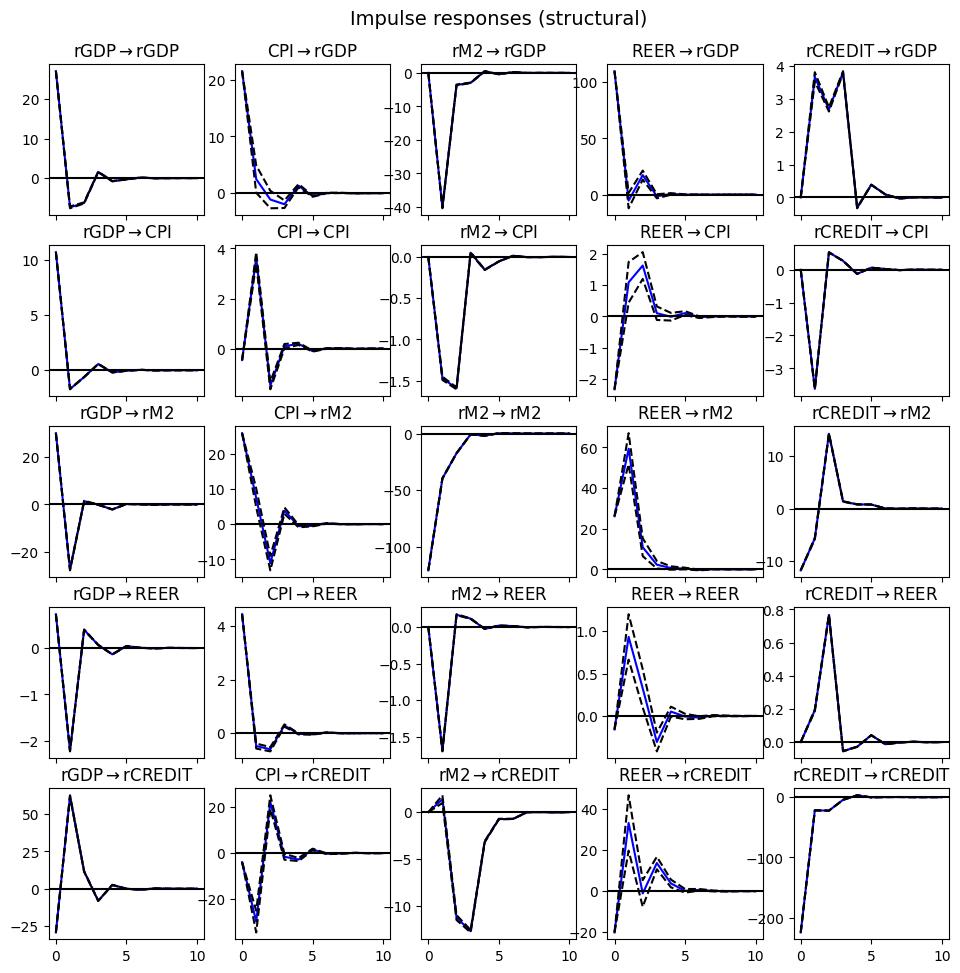

In [37]:
svar_model.irf().plot();

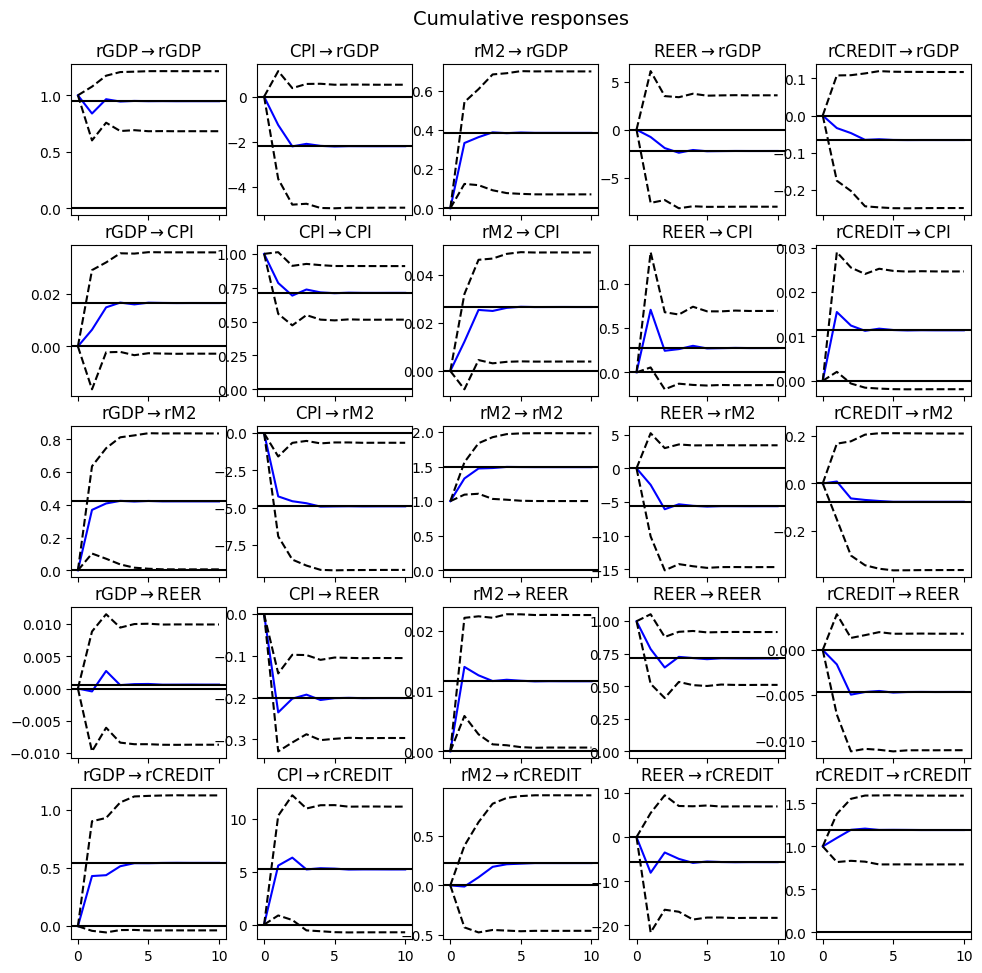

In [38]:
svar_model.irf().plot_cum_effects();